# Top overlapping annotations by weighted sum for ecoli cohort

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read token information from bed files

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'ECOLI')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,1,3,GAA,0.024555,AH21B049
1,1,4,12,AAACCCCGG,0.019281,AH21B049
2,1,13,17,TCAAT,0.042749,AH21B049
3,1,18,22,AAGGC,0.058446,AH21B049
4,1,23,27,CGGGG,-0.002272,AH21B049
...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077
247349729,5,259939,259942,GGCC,0.024973,ALF22C077


In [3]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,1,3,GAA,0.024555,AH21B049,3
1,1,4,12,AAACCCCGG,0.019281,AH21B049,9
2,1,13,17,TCAAT,0.042749,AH21B049,5
3,1,18,22,AAGGC,0.058446,AH21B049,5
4,1,23,27,CGGGG,-0.002272,AH21B049,5
...,...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077,8
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077,8
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077,10
247349729,5,259939,259942,GGCC,0.024973,ALF22C077,4


In [4]:
len(bedDf.tokens.unique())

31990

In [5]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.10044996853550375)

In [6]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
790,1,5456,5461,TTCCGG,0.109817,AH21B049,6
1113,1,7709,7713,CCGAC,0.111683,AH21B049,5
1141,1,7901,7906,GGTTTT,0.126671,AH21B049,6
1147,1,7939,7943,GACAG,0.138056,AH21B049,5
1544,1,10694,10701,CCCGACGG,0.119595,AH21B049,8
...,...,...,...,...,...,...,...
247348343,5,250450,250457,CCCTTTTT,0.104689,ALF22C077,8
247348387,5,250737,250741,ACAGA,0.114884,ALF22C077,5
247349058,5,255352,255357,GAAAAA,0.100641,ALF22C077,6
247349081,5,255503,255508,ACGCTG,0.112193,ALF22C077,6


In [7]:
len(highscoreDf.tokens.unique())

13592

In [8]:
highscoreDf.shape

(3266793, 7)

In [9]:
highscoreDf.token_length.value_counts()

token_length
6     1005832
7      585361
5      449264
8      339503
9      263575
4      262709
3      186469
10      92597
2       40984
11      30865
1        4650
12       2730
16       1991
15        152
13        102
14          9
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

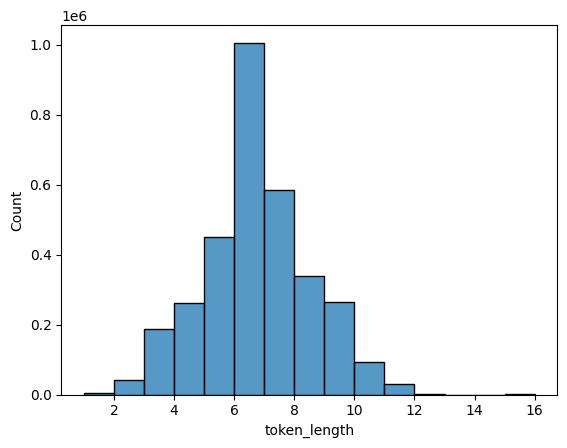

In [10]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read bed files containing overlapping tokens and attribution scores

In [11]:
from tqdm import tqdm

import os
import pandas as pd
from pathlib import Path


overlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'ECOLI')

overlappingDfList = []
for overlappingFile in tqdm(os.listdir(overlappingFilesDir)):
    df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df = df[df.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
    df['tube_code'] = [overlappingFile.split('_')[0]]*df.shape[0]
    df = df[df.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
    df['gene'] = df.gene.str.lower()
    overlappingDfList.append(df)
overlappingDf = pd.concat(overlappingDfList, ignore_index=True)
overlappingDf = overlappingDf.drop_duplicates()
overlappingDf

  0%|          | 0/358 [00:00<?, ?it/s]

100%|██████████| 358/358 [05:06<00:00,  1.17it/s]


,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,0,1,665,671,GAATCAT,0.037687,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
1,1,1,672,680,TTTATGAAT,0.023426,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
2,3,1,684,689,AAAACC,0.024358,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
3,4,1,690,698,TTCACCCAG,0.031550,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
4,5,1,699,708,ATCGCTATTG,0.008409,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
...,...,...,...,...,...,...,...,...,...,...,...,...
83835702,301834,5,357109,357119,CGGCAGACGAA,0.017858,CDS,KCGHAI_11840,Phage-related protein%2C tail assembly protein I,NaN,"ID=KCGHAI_11840;Name=Phage-related protein%2C tail assembly protein I;locus_tag=KCGHAI_11840;product=Phage-related protein%2C tail assembly protein I;Dbxref=COG:COG4723,COG:X,RefSeq:WP_000847668.1,SO:0001217,UniParc:UPI00016DBD2D,UniRef:UniRef100_A0A0A6RKN9,UniRef:UniRef50_F4V9K2,UniRef:UniRef90_A0A369FJA2",AH19F069
83835703,301835,5,357120,357125,GGGGAT,0.030131,CDS,KCGHAI_11840,Phage-related protein%2C tail assembly protein I,NaN,"ID=KCGHAI_11840;Name=Phage-related protein%2C tail assembly protein I;locus_tag=KCGHAI_11840;product=Phage-related protein%2C tail assembly protein I;Dbxref=COG:COG4723,COG:X,RefSeq:WP_000847668.1,SO:0001217,UniParc:UPI00016DBD2D,UniRef:UniRef100_A0A0A6RKN9,UniRef:UniRef50_F4V9K2,UniRef:UniRef90_A0A369FJA2",AH19F069
83835704,301836,5,357126,357131,GGTGGT,0.045921,CDS,KCGHAI_11840,Phage-related protein%2C tail assembly protein I,NaN,"ID=KCGHAI_11840;Name=Phage-related protein%2C tail assembly protein I;locus_tag=KCGHAI_11840;product=Phage-related protein%2C tail assembly protein I;Dbxref=COG:COG4723,COG:X,RefSeq:WP_000847668.1,SO:0001217,UniParc:UPI00016DBD2D,UniRef:UniRef100_A0A0A6RKN9,UniRef:UniRef50_F4V9K2,UniRef:UniRef90_A0A369FJA2",AH19F069
83835705,301837,5,357132,357138,CAGGTTG,-0.022747,CDS,KCGHAI_11840,Phage-related protein%2C tail assembly protein I,NaN,"ID=KCGHAI_11840;Name=Phage-related protein%2C tail assembly protein I;locus_tag=KCGHAI_11840;product=Phage-related protein%2C tail assembly protein I;Dbxref=COG:COG4723,COG:X,RefSeq:WP_000847668.1,SO:0001217,UniParc:UPI00016DBD2D,UniRef:UniRef100_A0A0A6RKN9,UniRef:UniRef50_F4V9K2,UniRef:UniRef90_A0A369FJA2",AH19F069


## Get overlapping tokens for high-score tokens

In [12]:
highscoreTokenOverlapsDf = overlappingDf.merge(
    highscoreDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
highscoreTokenOverlapsDf

,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,283,1,3240,3248,ACACCAGAT,0.111607,CDS,IGMLFD_00015,taurine ABC transporter ATP-binding subunit,taub,"ID=IGMLFD_00015;Name=taurine ABC transporter ATP-binding subunit;locus_tag=IGMLFD_00015;product=taurine ABC transporter ATP-binding subunit;Dbxref=COG:COG4525,COG:P,EC:7.6.2.7,GO:0005524,GO:0005886,RefSeq:WP_000939359.1,SO:0001217,UniParc:UPI00005EFB34,UniRef:UniRef100_Q0TKS1,UniRef:UniRef50_Q47538,UniRef:UniRef90_Q47538;gene=tauB",AH19C036
1,283,1,3240,3248,ACACCAGAT,0.111607,CDS,IGMLFD_00015,taurine ABC transporter ATP-binding subunit,taub,"ID=IGMLFD_00015;Name=taurine ABC transporter ATP-binding subunit;locus_tag=IGMLFD_00015;product=taurine ABC transporter ATP-binding subunit;Dbxref=COG:COG4525,COG:P,EC:7.6.2.7,GO:0005524,GO:0005886,RefSeq:WP_000939359.1,SO:0001217,UniParc:UPI00005EFB34,UniRef:UniRef100_Q0TKS1,UniRef:UniRef50_Q47538,UniRef:UniRef90_Q47538;gene=tauB",AH19C036
2,283,1,3240,3248,ACACCAGAT,0.111607,CDS,IGMLFD_00015,taurine ABC transporter ATP-binding subunit,taub,"ID=IGMLFD_00015;Name=taurine ABC transporter ATP-binding subunit;locus_tag=IGMLFD_00015;product=taurine ABC transporter ATP-binding subunit;Dbxref=COG:COG4525,COG:P,EC:7.6.2.7,GO:0005524,GO:0005886,RefSeq:WP_000939359.1,SO:0001217,UniParc:UPI00005EFB34,UniRef:UniRef100_Q0TKS1,UniRef:UniRef50_Q47538,UniRef:UniRef90_Q47538;gene=tauB",AH19C036
3,283,1,3240,3248,ACACCAGAT,0.111607,CDS,IGMLFD_00015,taurine ABC transporter ATP-binding subunit,taub,"ID=IGMLFD_00015;Name=taurine ABC transporter ATP-binding subunit;locus_tag=IGMLFD_00015;product=taurine ABC transporter ATP-binding subunit;Dbxref=COG:COG4525,COG:P,EC:7.6.2.7,GO:0005524,GO:0005886,RefSeq:WP_000939359.1,SO:0001217,UniParc:UPI00005EFB34,UniRef:UniRef100_Q0TKS1,UniRef:UniRef50_Q47538,UniRef:UniRef90_Q47538;gene=tauB",AH19C036
4,283,1,3240,3248,ACACCAGAT,0.111607,CDS,IGMLFD_00015,taurine ABC transporter ATP-binding subunit,taub,"ID=IGMLFD_00015;Name=taurine ABC transporter ATP-binding subunit;locus_tag=IGMLFD_00015;product=taurine ABC transporter ATP-binding subunit;Dbxref=COG:COG4525,COG:P,EC:7.6.2.7,GO:0005524,GO:0005886,RefSeq:WP_000939359.1,SO:0001217,UniParc:UPI00005EFB34,UniRef:UniRef100_Q0TKS1,UniRef:UniRef50_Q47538,UniRef:UniRef90_Q47538;gene=tauB",AH19C036
...,...,...,...,...,...,...,...,...,...,...,...,...
2164626,297478,5,321578,321583,GGTTTT,0.124395,CDS,KCGHAI_11550,Putative defective protein IntQ,intq,"ID=KCGHAI_11550;Name=Putative defective protein IntQ;locus_tag=KCGHAI_11550;product=Putative defective protein IntQ;Dbxref=GO:0003677,GO:0006310,GO:0015074,GO:0044826,GO:0046718,GO:0075713,RefSeq:WP_000876958.1,SO:0001217,UniParc:UPI0001C32917,UniRef:UniRef100_A0A0A0H666,UniRef:UniRef50_P76168,UniRef:UniRef90_P76168;gene=intQ",AH19F069
2164627,299223,5,335706,335712,CAGCGCA,0.115551,CDS,KCGHAI_11690,Antitermination protein Q,NaN,"ID=KCGHAI_11690;Name=Antitermination protein Q;locus_tag=KCGHAI_11690;product=Antitermination protein Q;Dbxref=RefSeq:WP_001529155.1,SO:0001217,UniParc:UPI0002A2A7F1,UniRef:UniRef100_UPI0002A2A7F1,UniRef:UniRef50_K7PKS8,UniRef:UniRef90_A0A653FU69",AH19F069
2164628,299903,5,343320,343326,TTCTCTG,0.137057,CDS,KCGHAI_11750,Terminase%2C large subunit,NaN,"ID=KCGHAI_11750;Name=Terminase%2C large subunit;locus_tag=KCGHAI_11750;product=Terminase%2C large subunit;Dbxref=COG:COG5525,COG:X,EC:3.1.21.4,GO:0003678,GO:0004519,GO:0005524,GO:0009036,GO:0016887,GO:0019073,GO:0030430,GO:0046872,GO:0098009,KEGG:K21512,RefSeq:WP_001027293.1,SO:0001217,UniParc:UPI0000F0C48A,UniRef:UniRef100_A0A2G9A2D2,UniRef:UniRef50_P03708,UniRef:UniRef90_P03708",AH19F069
2164629,300264,5,345806,345814,GTTACCTTC,0.102600,CDS,KCGHAI_11760,phage portal protein,NaN,"ID=KCGHAI_11760;Name=phage portal protein;locus_tag=KCGHAI_11760;product=phage portal protein;Dbxref=COG:COG5511,COG:X,GO:0003677,GO:0005198,GO:0019068,GO:0046798,GO:0099001,RefSeq:WP_001529148.1,SO:0001217,UniParc:UPI00016DBD38,UniR

## Calculate weighted sum for all genes

In [14]:
import numpy as np


geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_25135/2423154480.py:4: FutureWarning: The provided callable <function sum at 0x7f1a546603a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,gene,weighted_sum
0,6s,4.710385
1,aada1,0.344464
2,aaea,96.664124
3,aaeb,203.875719
4,aaer,28.625057
...,...,...
4365,zoro,1.250781
4366,zras,0.105720
4367,zupt,53.861828
4368,zur,2.640610


## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

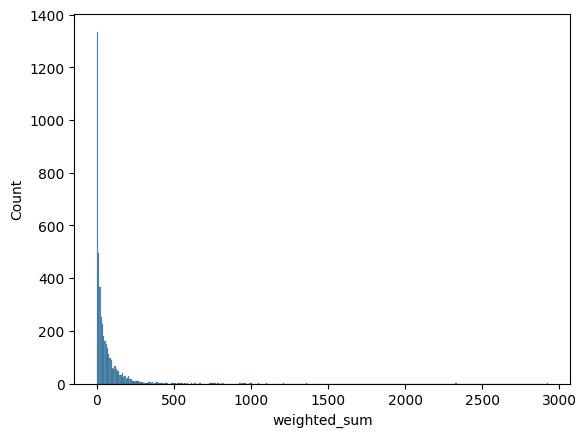

In [15]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [16]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]

,gene,weighted_sum
39,acrs,2926.868077
3932,yhdz,2333.133975
18,accc,1356.848448
351,ccma,1214.694417
1035,ftsh,1094.733786
1357,hsca,1052.384850
3930,yhdx,1004.086351
3924,yhdj,990.997389
3002,tref,963.444221
1933,nank,955.143446


## Create gene-type lookup table from amrfinderplus annotations

In [17]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_25135/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [18]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf['Gene symbol'] = genetypeLookupDf['Gene symbol'].str.lower()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icac,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepa,AMR
...,...,...
55837,blapdc-58,AMR
56358,blaact-49,AMR
56951,blandm-4,AMR
56963,aac(6')-ib-cr,AMR


## Read vfdb info

In [19]:
import os
import pandas as pd
from pathlib import Path


vfdbInfoFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'VFDB_info.csv')
vfdbInfoDf = pd.read_csv(vfdbInfoFile)
vfdbInfoDf['Label'] = vfdbInfoDf['Label'].str.lower()
vfdbInfoDf

,Column,ID,Label,Description,Source,Class
0,1,c0393,vat,hemoglobin protease,Escherichia coli O6:K2:H1 CFT073 (UPEC),Autotransporters
1,2,APECO1_O1CoBM73,tsh,Tsh,Escherichia coli O1:K1:H7 (APEC),Autotransporters
2,3,Q673F0_ECOLX,rpea,putative SPATE autotransporter; similar to the SPATE proteins,Escherichia coli plasmid pRAP strain REPEC 83/39,Autotransporters
3,4,ECSF_4010,ecsf_4010,phage protein,Escherichia coli SE15,Autotransporters
4,5,EcSMS35_3921,ecsms35_3921,outer membrane autotransporter,Escherichia coli SMS-3-5 (environmental),Autotransporters
...,...,...,...,...,...,...
249,250,c5077,yddo,ABC transporter ATP-binding protein,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
250,251,c5078,c5078,oligopeptide ABC transporter,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
251,252,c5079,yddq,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
252,253,c5080,yddr,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes


## Read vf collection

In [20]:
import os
import pandas as pd
from pathlib import Path


vfCollectionDescriptionFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ecoli_VF_collection_description.tsv')
vfCollectionDescriptionDf = pd.read_csv(vfCollectionDescriptionFile, sep='\t')
vfCollectionDescriptionDf['gene'] = vfCollectionDescriptionDf['gene'].str.lower()
vfCollectionDescriptionDf

,gene,locus tag,accession number (protein_id),description,reference,source,class
0,aap,EC042_pAA055,NaN,dispersin,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
1,aata,EC042_pAA008,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
2,aatb,EC042_pAA009,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
3,aatc,EC042_pAA010,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
4,aatd,EC042_pAA011,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
...,...,...,...,...,...,...,...
1064,lngj,NaN,ABU50049,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1065,lngp,NaN,ABU50050,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1066,etsa,APECO1_O1CoBM197,YP_001481352,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene
1067,etsb,APECO1_O1CoBM198,YP_001481353,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene


## Read ABRicate

In [21]:
import os
import pandas as pd
from pathlib import Path


abricateFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ABRicate.csv')
abricateDf = pd.read_csv(abricateFile)
abricateDf['gene'] = abricateDf['gene'].str.lower()
abricateDf

,gene,type
0,aaa23990,heat-stable enterotoxin
1,aaa24093,heat labile enterotoxin type IIa A
2,aaa24094,heat labile enterotoxin type IIa B
3,apeco1_1753,hypothetical protein
4,apeco1_1761,hypothetical protein
...,...,...
2696,ygeh,transcriptional regulator
2697,yggr,
2698,yghg,
2699,yijp,


## Add gene descriptions to the top genes

In [22]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20].merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates()

,gene,name,weighted_sum,AMR Finder Type,VFDB Type,VF Collection Type
0,acrs,multidrug efflux transporter transcriptional repressor AcrS,2926.868077,NaN,NaN,NaN
1,yhdz,Uncharacterized amino-acid ABC transporter ATP-binding protein YhdZ,2333.133975,NaN,NaN,NaN
2,accc,acetyl-CoA carboxylase biotin carboxylase subunit,1356.848448,NaN,NaN,NaN
3,ccma,cytochrome c biogenesis heme-transporting ATPase CcmA,1214.694417,NaN,NaN,NaN
4,ccma,heme ABC exporter ATP-binding protein CcmA,1214.694417,NaN,NaN,NaN
5,ftsh,ATP-dependent zinc metalloprotease FtsH,1094.733786,NaN,NaN,NaN
6,hsca,Fe-S protein assembly chaperone HscA,1052.384850,NaN,NaN,NaN
7,yhdx,Putative amino-acid ABC transporter permease protein YhdX,1004.086351,NaN,NaN,NaN
8,yhdj,adenine-specific DNA-methyltransferase,990.997389,NaN,NaN,NaN
9,yhdj,DNA modification methylase,990.997389,NaN,NaN,NaN


## Save all gene hits

In [24]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'ecoli_top_genes_overlaping_3sd_tokens.csv')

geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
)[['gene', 'name', 'weighted_sum']].drop_duplicates().to_csv(outputFile, index=False)

## Create annotations data matrix

In [31]:

signatureAnnotationsDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['gene'].isin(geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['gene'])]
signatureAnnotationsDf


,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
3543,106243,2,62972,62978,ATCACCG,0.061760,CDS,IGMLFD_04250,Fe-S protein assembly chaperone HscA,hsca,"ID=IGMLFD_04250;Name=Fe-S protein assembly chaperone HscA;locus_tag=IGMLFD_04250;product=Fe-S protein assembly chaperone HscA;Dbxref=COG:COG0443,COG:O,GO:0005524,GO:0016226,GO:0016887,GO:0051082,GO:0140662,RefSeq:WP_001196613.1,SO:0001217,UniParc:UPI000012CCD8,UniRef:UniRef100_B7MIL6,UniRef:UniRef50_Q8ZCS5,UniRef:UniRef90_Q8FF44;gene=hscA",AH19C036
3590,109014,2,83969,83974,GAAAAA,0.112015,CDS,IGMLFD_04335,ribosome biogenesis GTPase Der,der,"ID=IGMLFD_04335;Name=ribosome biogenesis GTPase Der;locus_tag=IGMLFD_04335;product=ribosome biogenesis GTPase Der;Dbxref=COG:COG1160,COG:J,GO:0005525,GO:0042254,RefSeq:WP_001350310.1,SO:0001217,UniParc:UPI0001610B69,UniRef:UniRef100_B7MHZ6,UniRef:UniRef50_Q2SDW8,UniRef:UniRef90_B7NQW0;gene=der",AH19C036
3591,109015,2,83975,83979,CCGAC,0.123019,CDS,IGMLFD_04335,ribosome biogenesis GTPase Der,der,"ID=IGMLFD_04335;Name=ribosome biogenesis GTPase Der;locus_tag=IGMLFD_04335;product=ribosome biogenesis GTPase Der;Dbxref=COG:COG1160,COG:J,GO:0005525,GO:0042254,RefSeq:WP_001350310.1,SO:0001217,UniParc:UPI0001610B69,UniRef:UniRef100_B7MHZ6,UniRef:UniRef50_Q2SDW8,UniRef:UniRef90_B7NQW0;gene=der",AH19C036
3592,109040,2,84140,84146,GCACCGC,0.138114,CDS,IGMLFD_04335,ribosome biogenesis GTPase Der,der,"ID=IGMLFD_04335;Name=ribosome biogenesis GTPase Der;locus_tag=IGMLFD_04335;product=ribosome biogenesis GTPase Der;Dbxref=COG:COG1160,COG:J,GO:0005525,GO:0042254,RefSeq:WP_001350310.1,SO:0001217,UniParc:UPI0001610B69,UniRef:UniRef100_B7MHZ6,UniRef:UniRef50_Q2SDW8,UniRef:UniRef90_B7NQW0;gene=der",AH19C036
3593,109111,2,84650,84655,ACGCTG,0.146530,CDS,IGMLFD_04335,ribosome biogenesis GTPase Der,der,"ID=IGMLFD_04335;Name=ribosome biogenesis GTPase Der;locus_tag=IGMLFD_04335;product=ribosome biogenesis GTPase Der;Dbxref=COG:COG1160,COG:J,GO:0005525,GO:0042254,RefSeq:WP_001350310.1,SO:0001217,UniParc:UPI0001610B69,UniRef:UniRef100_B7MHZ6,UniRef:UniRef50_Q2SDW8,UniRef:UniRef90_B7NQW0;gene=der",AH19C036
...,...,...,...,...,...,...,...,...,...,...,...,...
2164218,255687,4,357321,357329,AATGACGTC,0.116171,CDS,KCGHAI_09850,multidrug efflux RND transporter permease subunit AcrF,acrf,"ID=KCGHAI_09850;Name=multidrug efflux RND transporter permease subunit AcrF;locus_tag=KCGHAI_09850;product=multidrug efflux RND transporter permease subunit AcrF;Dbxref=BlastRules:WP_001273238,GO:0005886,GO:0015562,GO:0042910,GO:0140330,GO:1990281,NCBIProtein:AAC76298.1,RefSeq:WP_001273256.1,SO:0001217,UniParc:UPI0000D50CD0,UniRef:UniRef100_A0A061YNG9,UniRef:UniRef50_P24181,UniRef:UniRef90_P24181;gene=acrF",AH19F069
2164219,255691,4,357347,357352,GCTAAC,0.127252,CDS,KCGHAI_09850,multidrug efflux RND transporter permease subunit AcrF,acrf,"ID=KCGHAI_09850;Name=multidrug efflux RND transporter permease subunit AcrF;locus_tag=KCGHAI_09850;product=multidrug efflux RND transporter permease subunit AcrF;Dbxref=BlastRules:WP_001273238,GO:0005886,GO:0015562,GO:0042910,GO:0140330,GO:1990281,NCBIProtein:AAC76298.1,RefSeq:WP_001273256.1,SO:0001217,UniParc:UPI0000D50CD0,UniRef:UniRef100_A0A061YNG9,UniRef:UniRef50_P24181,UniRef:UniRef90_P24181;gene=acrF",AH19F069
2164220,255710,4,357471,357476,CGTCCT,0.120348,CDS,KCGHAI_09850,multidrug efflux RND transporter permease subunit AcrF,acrf,"ID=KCGHAI_09850;Name=multidrug efflux RND transporter permease subunit AcrF;locus_tag=KCGHAI_09850;product=multidrug efflux RND transporter permease subunit AcrF;Dbxref=BlastRules:WP_001273238,GO:0005886,GO:0015562,GO:0042910,GO:0140330,GO:1990281,NCBIProtein:AAC76298.1,RefSeq:WP_001273256.1,SO:0001217,UniParc:UPI0000D50CD0,UniRef:UniRef100_A0A061YNG9,UniRef:UniRef50_P24181,UniRef:UniRef90_P24181;gene=acrF",AH19F069
2164221,256331,4,362535,362540,GGGCTG,0.110714,CDS,KCGHAI_09880,Uncharacterized amino-acid ABC transporter ATP-binding protein YhdZ,yhdz,"ID=KCGHAI_0988

In [32]:
signatureDataDf = signatureAnnotationsDf[['tube_code', 'gene']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['gene'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('gene',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf

,tube_code,accc,acrf,acrs,ccma,dead,der,ftsh,gltb,hsca,lepb,nank,tref,xylg,yden,yhdj,yhdp,yhdu,yhdx,yhdz,yhfr
3543,AH19C036,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3590,AH19C036,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6780,AH19C036,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6832,AH19C036,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6848,AH19C036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164158,AH19F069,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2164167,AH19F069,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2164190,AH19F069,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2164196,AH19F069,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Read mapping information

In [33]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [34]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [35]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read mortality labels

In [36]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_validate.csv'), sep='\t')
mortalityDf = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortalityDf

,person_id,JOURNEY_ID,visit_occurrence_id,death_30_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
2,2107813,9410987,9410987,1
5,2083212,9039437,602890,0
6,2083212,9039437,9039437,0
...,...,...,...,...
30815,2603535,16588204,16588204,0
30820,2603535,16709341,16709341,0
30832,2603535,16651755,16651755,0
30838,2098616,16872774,16872774,0


## Create datamatrix

In [37]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='inner'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_30_day,accc,acrf,acrs,ccma,dead,der,ftsh,gltb,hsca,lepb,nank,tref,xylg,yden,yhdj,yhdp,yhdu,yhdx,yhdz,yhfr
0,2100650,603830,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2100650,603830,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2100650,603830,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2100650,603830,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2100650,603830,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,2301778,13933070,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
285,2301778,13933070,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
286,2301778,13933070,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
287,2301778,13933070,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Calculate correlation

In [57]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_30_day,accc,acrf,acrs,ccma,dead,der,ftsh,gltb,hsca,lepb,nank,tref,xylg,yden,yhdj,yhdp,yhdu,yhdx,yhdz,yhfr
death_30_day,1.000000,0.004487,0.002189,0.052289,0.000554,-0.022336,-0.032504,-0.018037,-0.039170,-0.096961,-0.047171,0.038599,0.012937,0.029555,0.052123,0.040507,0.009988,0.036531,0.014128,0.040507,-0.066399
acrs,0.052289,-0.048968,-0.066786,1.000000,-0.055933,-0.047101,-0.041088,-0.065313,-0.069670,-0.047101,-0.034193,-0.043171,-0.022228,-0.050779,-0.041088,-0.048968,-0.065313,-0.028797,-0.059177,-0.048968,-0.038910
yden,0.052123,-0.042716,-0.058259,-0.041088,-0.048792,-0.041088,-0.035842,-0.056975,-0.060776,-0.041088,-0.029828,-0.037659,-0.019390,-0.044296,1.000000,-0.042716,-0.056975,-0.025120,-0.051622,-0.042716,-0.033942
yhdz,0.040507,-0.050909,-0.069433,-0.048968,-0.058150,-0.048968,-0.042716,-0.067902,-0.072432,-0.048968,-0.035549,-0.044882,-0.023109,-0.052792,-0.042716,-0.050909,-0.067902,-0.029938,-0.061523,1.000000,-0.040452
yhdj,0.040507,-0.050909,-0.069433,-0.048968,-0.058150,-0.048968,-0.042716,-0.067902,-0.072432,-0.048968,-0.035549,-0.044882,-0.023109,-0.052792,-0.042716,1.000000,-0.067902,-0.029938,-0.061523,-0.050909,-0.040452
nank,0.038599,-0.044882,-0.061213,-0.043171,-0.051266,-0.043171,-0.037659,-0.059863,-0.063857,-0.043171,-0.031340,1.000000,-0.020373,-0.046542,-0.037659,-0.044882,-0.059863,-0.026394,-0.054239,-0.044882,-0.035663
yhdu,0.036531,-0.029938,-0.040831,-0.028797,-0.034196,-0.028797,-0.025120,-0.039931,-0.042595,-0.028797,-0.020905,-0.026394,-0.013589,-0.031045,-0.025120,-0.029938,-0.039931,1.000000,-0.036180,-0.029938,-0.023789
xylg,0.029555,-0.052792,-0.072001,-0.050779,-0.060301,-0.050779,-0.044296,-0.070413,-0.075111,-0.050779,-0.036863,-0.046542,-0.023963,1.000000,-0.044296,-0.052792,-0.070413,-0.031045,-0.063798,-0.052792,-0.041948
yhdx,0.014128,-0.061523,-0.083909,-0.059177,-0.070273,-0.059177,-0.051622,-0.082058,-0.087533,-0.059177,-0.042960,-0.054239,-0.027926,-0.063798,-0.051622,-0.061523,-0.082058,-0.036180,1.000000,-0.061523,-0.048886
tref,0.012937,-0.023109,-0.031517,-0.022228,-0.026395,-0.022228,-0.019390,-0.030822,-0.032878,-0.022228,-0.016136,-0.020373,1.000000,-0.023963,-0.019390,-0.023109,-0.030822,-0.013589,-0.027926,-0.023109,-0.018362


## Plot correlations as a heatmap

<Axes: >

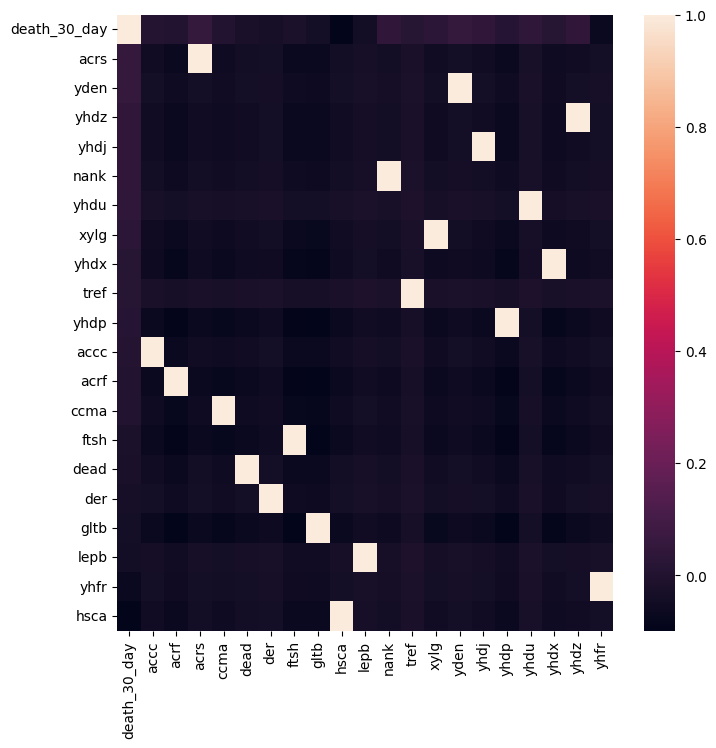

In [58]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False))

## Plot correlations as a heatmap (Log scale)

<Axes: >

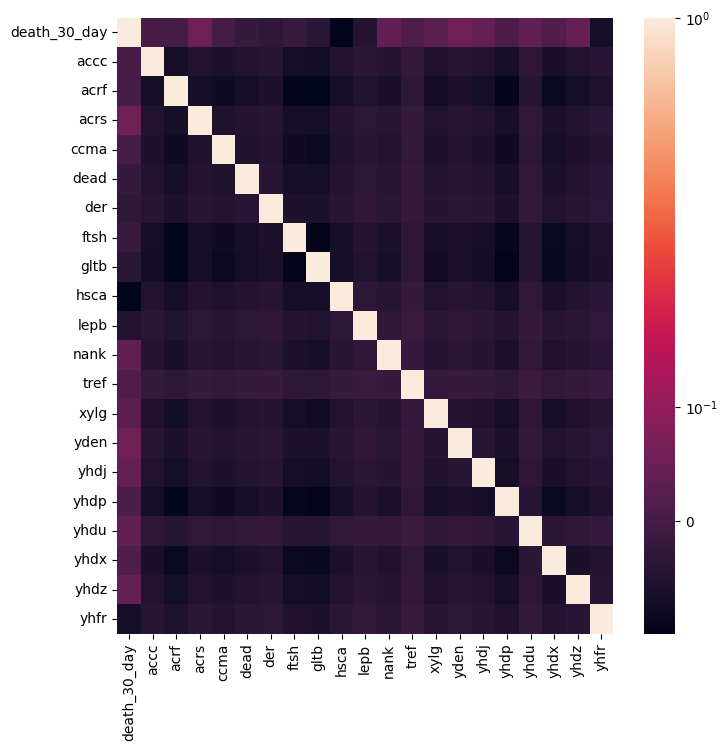

In [54]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

## Model using machine learning

In [42]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day'])
y = dataDf.death_30_day

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.3103448275862069

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.7413793103448276

In [50]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
8,hsca,-1.069325
19,yhfr,-0.514808
7,gltb,-0.482012
9,lepb,-0.425787
4,dead,-0.279481
3,ccma,-0.255343
5,der,-0.192986
0,accc,-0.111235
6,ftsh,-0.072413
18,yhdz,0.061032


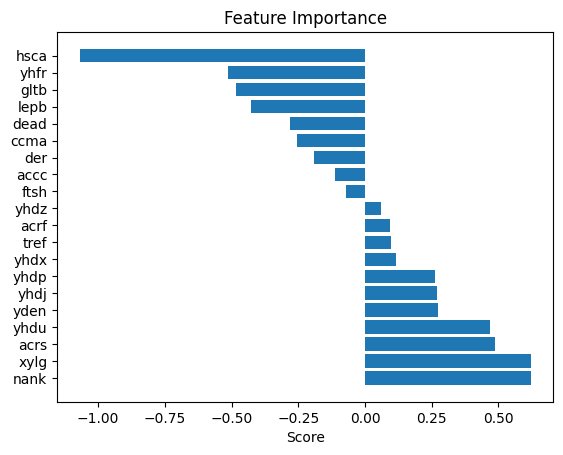

In [51]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()
